# <font color='green'>**Big Mart Sales Prediction - Yemi Adeogun**
This notebook Predict Sales of Big Mart based on Item and Outlet details
using XGBoost model</font>

##  **Import Libraries**

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

## **Exploratory Data Analysis (EDA)**

In [99]:
# loading the train and the test data from csv file to Pandas DataFrame
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')


In [100]:
# first 5 rows of the train dataframe
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [101]:
# first 5 rows of the test dataframe
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [102]:
# number of data points & number of features
train.shape

(8523, 12)

In [103]:
test.shape

(5681, 11)

In [104]:
# Add both dataset into a colunn named Source and Combine into one to create a new dataframe

train['source'] = 'train'

In [105]:
test['source'] = 'test'

In [106]:
train_test=pd.concat([train,test],ignore_index=True)

In [107]:
# getting some information about the dataset
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usag

## **Missing Values**

In [108]:
# Checking for missing values in the new dataset

train_test.apply(lambda x:sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [109]:
# Getting Statistical values on the dataset

train_test.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [110]:
# Fill the missing values in the item weight column with the mean value of itself
# If you check the describe table above, you'' see the mean value of the Item Weight Column

train_test['Item_Weight'].fillna(train_test['Item_Weight'].mean(),inplace=True)

In [111]:
# Fill in the missing values in the Outlet Size column with the mode value of itself
# Meaning the value that appears the most

train_test['Outlet_Size'] = train_test['Outlet_Size'].replace(np.nan,'Mode')

In [112]:
# The number of outlets in the dataset base on size

train['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

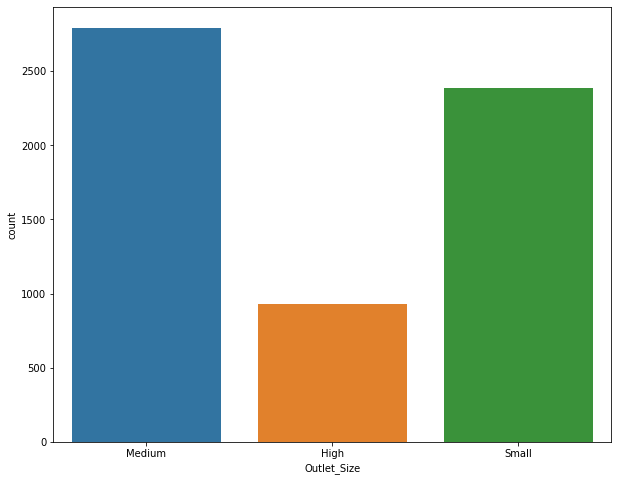

In [113]:
# Visualization showing the number of outlets in the dataset base on size

plt.figure(figsize=(10,8))
sns.countplot(train.Outlet_Size)
plt.show()

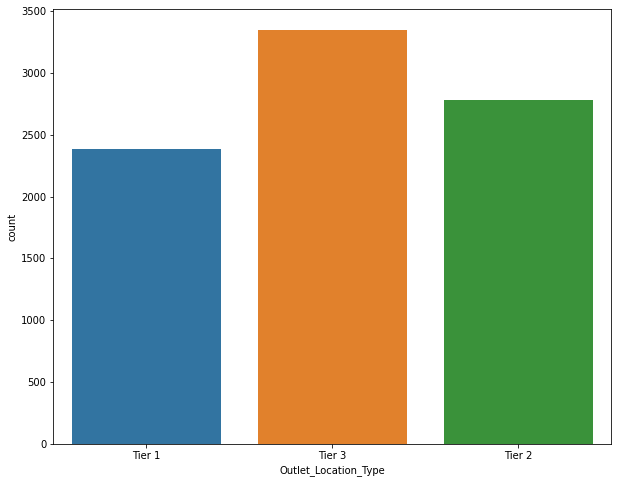

In [114]:
# Visualization showing the number of outlet locations in the dataset base on outlet location type

plt.figure(figsize=(10,8))
sns.countplot(train.Outlet_Location_Type)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

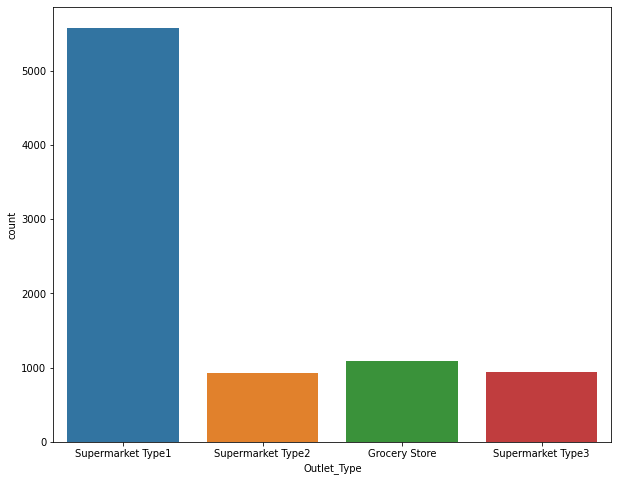

In [115]:
# Visualization showing the number of outlets in the dataset base on outlet type

plt.figure(figsize=(10,8))
sns.countplot(train.Outlet_Type)
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

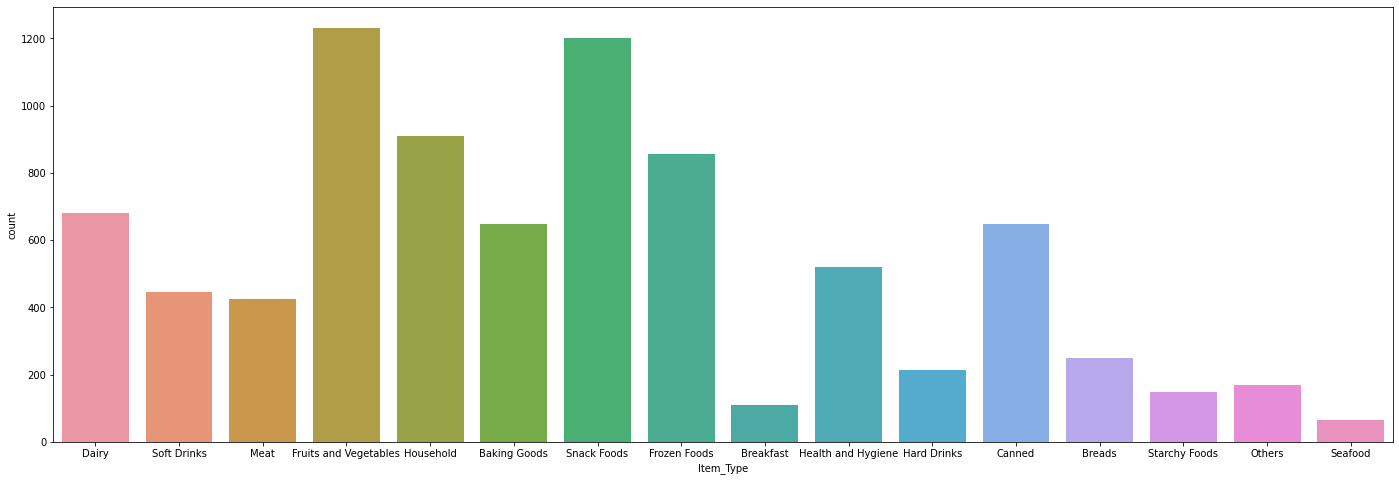

In [116]:
# Visualization showing the number of items in the dataset base on item type

plt.figure(figsize=(24,8))
sns.countplot(train.Item_Type)
plt.xticks(rotation=0)

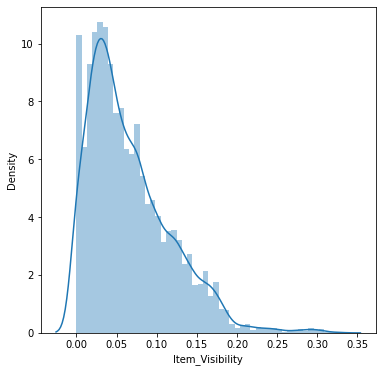

In [117]:
# Visualization showing the number of items in the dataset base on item visibility

plt.figure(figsize=(6,6))
sns.distplot(train['Item_Visibility'])
plt.show()

In [118]:
# Now all the missing values have been filled in
# The Item_Outlet _Sales is from the test dataset that i will use to test our model

train_test.apply(lambda x:sum(x.isnull()))

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

## **Feature Engineering**

In [119]:
# We need to merge the Item_Flat_Content values correctly

train_test['Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [120]:
train_test['Item_Fat_Content'] = train_test['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})

In [121]:
train_test['Item_Fat_Content'].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

In [122]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat', 'reg':'Regular'})

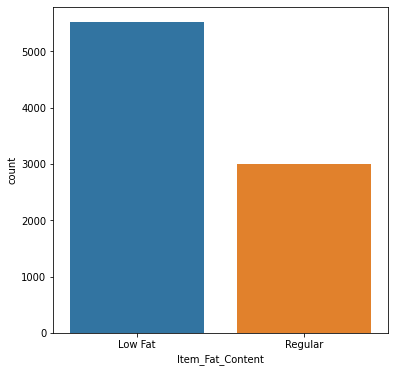

In [123]:
# Visualization showing the number Items based on Fat Content
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=train)
plt.show()

In [124]:
# THe item identifier needs to be properly renamed for all the categories

train_test['Item_Identifier'].value_counts()

FDU15    10
FDS25    10
FDA38    10
FDW03    10
FDJ10    10
         ..
FDR51     7
FDM52     7
DRN11     7
FDH58     7
NCW54     7
Name: Item_Identifier, Length: 1559, dtype: int64

In [125]:
train_test['Iten_Identifier_New'] = train_test['Item_Identifier'].apply(lambda x: x[0:2])

In [126]:
train_test['Iten_Identifier_New'] = train_test['Iten_Identifier_New'].map({'FD':'Food','NC':'Non_Consumable','DR':'Drinks'})

In [127]:
train_test['Iten_Identifier_New'].value_counts()

Food              10201
Non_Consumable     2686
Drinks             1317
Name: Iten_Identifier_New, dtype: int64

In [128]:
train_test.loc[train_test['Iten_Identifier_New']=="Non_Consumable","Item_Fat_Content"] = "Non-Edible"

In [129]:
train_test['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [130]:
train_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Iten_Identifier_New
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,Drinks
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,Food
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Mode,Tier 3,Grocery Store,732.3800,train,Food
4,NCD19,8.93,Non-Edible,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,Non_Consumable


Label Encoding

In [131]:
encoder = LabelEncoder()

In [132]:
# Convert all the categorical columns in the merged dataset to numerical

train_test['Iten_Identifier_New'] = encoder.fit_transform(train_test['Iten_Identifier_New'])

train_test['Item_Fat_Content'] = encoder.fit_transform(train_test['Item_Fat_Content'])

train_test['Item_Fat_Content'] = encoder.fit_transform(train_test['Item_Fat_Content'])

train_test['Outlet_Identifier'] = encoder.fit_transform(train_test['Outlet_Identifier'])

train_test['Outlet_Size'] = encoder.fit_transform(train_test['Outlet_Size'])

train_test['Outlet_Location_Type'] = encoder.fit_transform(train_test['Outlet_Location_Type'])

train_test['Outlet_Type'] = encoder.fit_transform(train_test['Outlet_Type'])

In [133]:
train_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Iten_Identifier_New
0,FDA15,9.30,0,0.016047,Dairy,249.8092,9,1999,1,0,1,3735.1380,train,1
1,DRC01,5.92,2,0.019278,Soft Drinks,48.2692,3,2009,1,2,2,443.4228,train,0
2,FDN15,17.50,0,0.016760,Meat,141.6180,9,1999,1,0,1,2097.2700,train,1
3,FDX07,19.20,2,0.000000,Fruits and Vegetables,182.0950,0,1998,2,2,0,732.3800,train,1
4,NCD19,8.93,1,0.000000,Household,53.8614,1,1987,0,2,1,994.7052,train,2


In [134]:
# Drop the columns that are not needed for the prediction model

train_test.drop(['Item_Type','Outlet_Establishment_Year'], axis=1, inplace=True)

In [135]:
# Extract the train dataset and the test dataset from the merged dataset for our prediction model

train = train_test.loc[train_test['source']=='train']
test = train_test.loc[train_test['source']=='test']

In [136]:
# Drop column that is not needed in the train dataset

train.drop(['source'], axis=1,inplace=True)

In [137]:
# Drop columns that is not needed in the train dataset

test.drop(['Item_Outlet_Sales','source'], axis=1,inplace=True)

In [138]:
# Assign dataset for prediction

X_train = train.drop(['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier'],axis=1).copy()
y_train = train['Item_Outlet_Sales']
X_test = test.drop(['Item_Identifier','Outlet_Identifier'], axis=1).copy()

## **Machine Learning Model Building**

XGBoost Regressor

In [139]:
# Machine Learning Model - XGBoost

from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=1000, learning_rate = 0.05)
model.fit(X_train,y_train)

[10:12:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.05, n_estimators=1000)

In [140]:
# Here is the result of the predictions on the test data

pred = model.predict(X_test)
pred

array([1404.8977 , 1474.5308 ,  786.02594, ..., 1833.2854 , 3643.5566 ,
       1333.1354 ], dtype=float32)

In [141]:
# Accuracy of the Prediction is Approx. 69%

model.score(X_train,y_train)*100

68.78645391971482